# Sparkify Project

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import sum as sparkSum, isnan, when, count, col, length, countDistinct, date_trunc, from_unixtime, datediff
from pyspark.sql.functions import monotonically_increasing_id, collect_list, udf, desc, min as sparkMin, max as sparkMax
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder\
    .master("local")\
    .appName('Sparkify')\
    .getOrCreate()

# Load and Clean Dataset
Using tiny subset (128MB) of the full dataset available (12GB) for local development.

Mini dataset: `s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json`

Full dataset: `s3n://udacity-dsnd/sparkify/sparkify_event_data.json`


In [3]:
# Uncomment to download

# import requests
# url = 'https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json'

# def download_file(url):
#     local_filename = url.split('/')[-1]
#     with requests.get(url, stream=True) as r:
#         r.raise_for_status()
#         with open(local_filename, 'wb') as f:
#             for chunk in r.iter_content(chunk_size=8192): 
#                 f.write(chunk)
#     return local_filename

# download_file(url)

In [4]:
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [5]:
# Check schema and column types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
print('Number of rows mini dataset', df.count())
print('Number of columns mini dataset', len(df.columns))
print('Number of duplicated rows in mini dataset', df.count() - df.dropDuplicates().count())

Number of rows mini dataset 286500
Number of columns mini dataset 18
Number of duplicated rows in mini dataset 0


#### Let's check our data for numerical columns:

In [9]:
numCols = [col[0] for col in df.dtypes if not col[1]=='string']; numCols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [10]:
df.select(numCols).describe().show()

+-------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|        sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+
|  count|            286500|           228108|              278154|           286500|            286500|              286500|
|   mean|114.41421291448516|249.1171819778458|1.535358834084427...|1041.526554973822|210.05459685863875|1.540956889810483...|
| stddev|129.76726201140994|99.23517921058361| 3.291321616327586E9|726.7762634630741| 31.50507848842214|1.5075439608226302E9|
|    min|                 0|          0.78322|       1521380675000|                1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|             2474|               404|       1543799

For some informations above (`registration`, `sessionId`, `status`, `ts`) it doesn't make sense to analyze as numbers. We will dive deeper in the next Exploratory Data Analysis session of this notebook.

#### Let's check our data for categorical columns:

In [11]:
text_cols = [col[0] for col in df.dtypes if col[1]=='string']; text_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

Although not expected by inspecting the data, `userId` is actually a string.

We check other information about our text data (not interested in `firstName` and `lastName`):

In [12]:
dist_artists = df.select(countDistinct('artist').alias('numberOfDistinctArtists')).withColumn("id", monotonically_increasing_id())

dist_songs = df.select(['song','artist']).groupBy('song').agg(countDistinct('artist').alias('countDistinctArtists')).\
    select(sparkSum('countDistinctArtists').alias('numberOfDistinctSongs')).withColumn("id", monotonically_increasing_id())

dist_user_agents = df.select(countDistinct('userAgent').alias('numberOfuserAgents')).withColumn("id", monotonically_increasing_id())

dist_locations = df.select(countDistinct('location').alias('numberOfDistinctLocations')).withColumn("id", monotonically_increasing_id())

text_cols_info = dist_artists.join(dist_songs, "id", "outer")\
                             .join(dist_user_agents, "id", "outer")\
                             .join(dist_locations, "id", "outer").drop('id')\

text_cols_info.show()

+-----------------------+---------------------+------------------+-------------------------+
|numberOfDistinctArtists|numberOfDistinctSongs|numberOfuserAgents|numberOfDistinctLocations|
+-----------------------+---------------------+------------------+-------------------------+
|                  17655|                65416|                56|                      114|
+-----------------------+---------------------+------------------+-------------------------+



Sparkify's mini dataset contains has 17655 different artists, 65416 songs, users in 114 different locations that use 56 different types of devices/software to access the app.

In [13]:
# We calculate value counts for:
text_cols_value_counts = ['auth',
                         'gender',
                         'level',
                         'method',
                         'page',
                         'status']

for column in text_cols_value_counts:
    df.select(column).groupBy(column).count().orderBy('count').show(30, truncate=False)

+----------+------+
|auth      |count |
+----------+------+
|Cancelled |52    |
|Guest     |97    |
|Logged Out|8249  |
|Logged In |278102|
+----------+------+

+------+------+
|gender|count |
+------+------+
|null  |8346  |
|M     |123576|
|F     |154578|
+------+------+

+-----+------+
|level|count |
+-----+------+
|free |58338 |
|paid |228162|
+-----+------+

+------+------+
|method|count |
+------+------+
|GET   |25436 |
|PUT   |261064|
+------+------+

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Submit Registration      |5     |
|Register                 |18    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Submit Downgrade         |63    |
|Submit Upgrade           |159   |
|Error                    |258   |
|Save Settings            |310   |
|Upgrade                  |499   |
|About                    |924   |
|Settings                 |1514  |
|Help                     |1726  |
|Downgrade   

#### Loading, cleaning the dataset and checking for invalid or missing data - for example, records without userids or sessionids. 

In [14]:
#Checking if there are NaNs
df.select([count(when(isnan(c), c)).alias(c+'IsNan') for c in df.columns]).toPandas()

,artistIsNan,authIsNan,firstNameIsNan,genderIsNan,itemInSessionIsNan,lastNameIsNan,lengthIsNan,levelIsNan,locationIsNan,methodIsNan,pageIsNan,registrationIsNan,sessionIdIsNan,songIsNan,statusIsNan,tsIsNan,userAgentIsNan,userIdIsNan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No Nans in the mini-dataset.

In [15]:
#Checking if there are null values
df.select([count(when(col(c).isNull(), c)).alias(c+'IsNull') for c in df.columns]).toPandas()

,artistIsNull,authIsNull,firstNameIsNull,genderIsNull,itemInSessionIsNull,lastNameIsNull,lengthIsNull,levelIsNull,locationIsNull,methodIsNull,pageIsNull,registrationIsNull,sessionIdIsNull,songIsNull,statusIsNull,tsIsNull,userAgentIsNull,userIdIsNull
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Appearently missing data is correlated (missing counts of columns consistently appear having 8346 or 58392 Null values).

Let's check how missing values are correlated:

In [16]:
# Check null values: 1 is null and 0 not null
df_is_null = df.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df.columns])

df_is_null_describe = df_is_null.describe()

df_is_null_describe = df_is_null_describe.filter(
    (df_is_null_describe['summary']=='stddev') | 
    (df_is_null_describe['summary'] == 'max')
)

# Handle the std equals to zero (all values are the same) and without any null value
zero_std_max_cols = [col for col in df_is_null_describe.columns if df_is_null_describe.select(collect_list(col)).head().asDict()['collect_list('+col+')'] == ['0.0', '0']]

# Drop all columns with Standard Deviation equals zero and no missing values
df_is_null = df_is_null.drop(*zero_std_max_cols)

# Create vectors 
assembler = VectorAssembler(inputCols=df_is_null.columns, outputCol='vector')
assembled = assembler.transform(df_is_null).drop(*df_is_null.columns)

# Calculate and print Pearson correlation matrix for missing values
pearson_corr = Correlation.corr(assembled, 'vector').head()
pearson_corr = pd.DataFrame(data=pearson_corr[0].toArray(), columns=df_is_null.columns, index=df_is_null.columns)

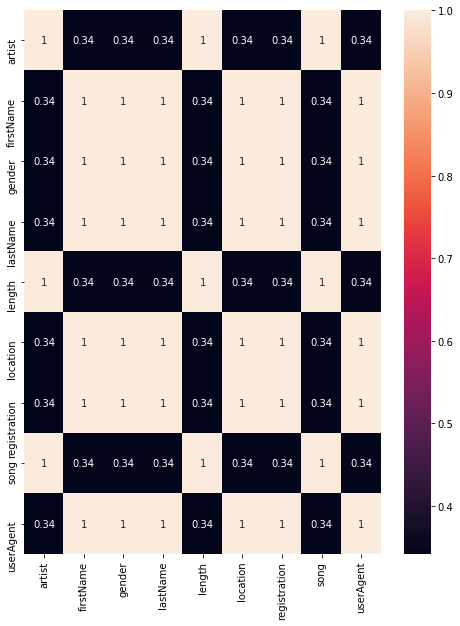

In [17]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pearson_corr, ax=ax, annot=True);

When there's a null in `artist` column also a null in `length` and `song` happen. Hence, this data may be related and length appears to be the length in seconds of songs. 

Similarly, data related to users are related and when a null happens in either `firstName`, `lastName`, `gender`, `location`, `userAgent` and `registration` the others are null too. The column registration seems to be related to the timestamp of when a user registers himself/herself in the application.

Let's check `userId`:

In [18]:
# userId is string and shold be always with length greater than 0
df.select('userId', length(col('userId')).alias('userIdLength')).distinct().orderBy(col('userIdLength')).show(5)

+------+------------+
|userId|userIdLength|
+------+------------+
|      |           0|
|     6|           1|
|     3|           1|
|     5|           1|
|     4|           1|
+------+------------+
only showing top 5 rows



In [19]:
# number of users with userId equals to ''
df.filter(df.userId=='').count()

8346

In the mini dataset there are 8346 users with userId equals to `''` (length of the string userId is zero). Perhaps those users without userId are those who have not signed up yet or that are signed out and are about to log in.

We'll drop them from our dataframe (in order for the analysis of individual users make sense):

In [20]:
# Drop userId equals to ''
df = df.filter(df.userId!='')

In [21]:
# Mini dataset has 286,500 rows. Hence we expect 286,500 - 8,346 = 278,154
df.count()

278154

In [22]:
print(f"There are {df.select('userId').distinct().count()} users in the mini dataset.")

There are 225 users in the mini dataset.


# Exploratory Data Analysis

### Define Churn

We create a column `Churn` to use as the label for our model. We choose the `Cancellation Confirmation` events to define the churn, which happen for both paid and free users. We also analyze the `Downgrade` events.

In [23]:
# Create Churn column
churner_ids = df.select('userId').where(col('page')=='Cancellation Confirmation').toPandas()

churner_ids = churner_ids.values.squeeze().tolist()
print('churner_ids:', churner_ids)

churner_ids: ['18', '32', '125', '105', '17', '143', '101', '129', '121', '51', '87', '122', '12', '58', '73', '3', '106', '103', '28', '54', '29', '70', '53', '100011', '100001', '100024', '100006', '100019', '100003', '100023', '100005', '100017', '100025', '100009', '100012', '100013', '100022', '100014', '100015', '100021', '100007', '200001', '200024', '200011', '200021', '200018', '200015', '200017', '200016', '200020', '300007', '300001']


In [24]:
is_churn = udf(lambda usrIdCol: 1 if usrIdCol in churner_ids else 0, IntegerType())
df = df.withColumn('churn', is_churn('userId'))

df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


### Explore Data
Analyzing the behavior for users who stayed vs users who churned. 
We explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Without knowing much about the business nor the actual application, we can think the following possible reasons why users cancel the service:
1. user is not using Sparkify
2. Sparkify doesn't have specific songs/artists
3. bad recommendations
4. bad experience (streaming getting stuck, interface not intuitive in version of app, too many ads in the app, etc.)
5. bugs (commands not responding or don't do what they should, crashes in the app, etc.)
6. Sparkify too expensive
7. don't have friends using Sparkify
8. external influences (some news about company benefits/harms its image, country where users live imposes some limits, cost increase, etc.)

From the hypothesis above:
- `1.` we can check by counting number of interations in a given timeframe
- `2.` we cannot check directly since we don't have logs for search queries which would be better (showing that the search query returned exactly what the user wanted) 
- `3.` we have the Add to Playlist, Thumbs Down and Thumbs Up `pages` which could indicate the quality of recommendations
- `4.` and `5.` we don't have application logs which could indicate loading times, interrupting streaming. However, <a href="https://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html#sec10.3.3">status</a> could give us some information about the application and the Error and Help `pages`. In addition, <a href="https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent">userAgent</a> can also give us some information about Sparkify applications that are not behaving as expected (Windows, MacOS, specific browser, platform, etc.). The Roll Advert `page` indicates Advertising events and if it is affecting too much user experience (if we could reduce it or enphasize that user can upgrade plan)
- `6.` as "expensive" may be an ambiguous definition and depend on many factors, with the dataset given we won't be able to infer anything.
- `7.` Add Friend `page` could indicate that friends are also using app (in the provided dataset we don't have relationships between users which would be better)
- `8.` again we would need more data related to the business and context to infer anything here

We check the data to answer those questions and compare customers who churn with those who don't:

In [26]:
not_churn_users = df.filter(col('churn')==0)
churn_users = df.filter(col('churn')==1)

In [44]:
num_churn_users = churn_users.select('userId').distinct().count()
num_not_churn_users = not_churn_users.select('userId').distinct().count()

In [45]:
# Sanity check (there should be 225 users in total)
num_churn_users + num_not_churn_users

225

#### 1. Understand how often users interact with Sparkify

In [34]:
# a. How many songs do users listen to on average between visiting our home page (calculation shown in the Udacity course)

fun = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum_churn = churn_users.filter((col('page') == 'NextSong') | (col('page') == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', fun(col('page'))) \
    .withColumn('period', sparkSum('homevisit').over(user_window))

cusum_churn = cusum_churn.filter((col('page') == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).withColumnRenamed('avg(count(period))', 'churnAvg(count(period))') \
    .withColumn("id", monotonically_increasing_id())

cusum_not_churn = not_churn_users.filter((col('page') == 'NextSong') | (col('page') == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', fun(col('page'))) \
    .withColumn('period', sparkSum('homevisit').over(user_window))

cusum_not_churn = cusum_not_churn.filter((col('page') == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).withColumnRenamed('avg(count(period))', 'notChurnAvg(count(period))') \
    .withColumn("id", monotonically_increasing_id())

result = cusum_churn.join(cusum_not_churn, "id", "outer").drop('id')\

result.show()

+-----------------------+--------------------------+
|churnAvg(count(period))|notChurnAvg(count(period))|
+-----------------------+--------------------------+
|       22.6612702366127|         23.79175974187143|
+-----------------------+--------------------------+



As we may have expected in the mini-dataset the number of songs users listen to on average between visiting our home page is higher in the not churn group than in the group of users who churn (they use more the Sparkify app, which could indicate they like it more).

In [46]:
# b. Calculating number of songs played given time frame

def add_time_columns(df):
    # Add hour column
    get_hour = udf(lambda x: int(datetime.fromtimestamp(x / 1000.0).hour), IntegerType())
    df_time = df.withColumn('hour', get_hour(df.ts))
    songs_in_hour = df_time.filter(df_time.page == 'NextSong').groupby('hour').count().orderBy('hour')
    songs_in_hour_pd = songs_in_hour.toPandas()

    # Add weekday column
    get_weekday = udf(lambda x: int(datetime.fromtimestamp(x / 1000.0).weekday()), IntegerType())
    df_time = df_time.withColumn('weekday', get_weekday(df_time.ts))
    songs_in_weekday = df_time.filter(df_time.page == 'NextSong').groupby('weekday').count().orderBy('weekday')
    songs_in_weekday_pd = songs_in_weekday.toPandas()
    songs_in_weekday_pd.weekday = songs_in_weekday_pd.weekday.map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
    
    return songs_in_hour_pd, songs_in_weekday_pd

churn_songs_hour, churn_songs_weekday = add_time_columns(churn_users)
not_churn_songs_hour, not_churn_songs_weekday = add_time_columns(not_churn_users)

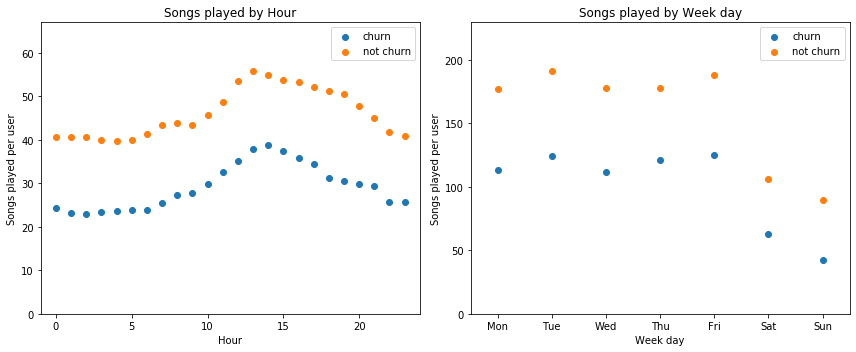

In [59]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(churn_songs_hour['hour'], churn_songs_hour['count']/num_churn_users, label='churn')
ax[0].scatter(not_churn_songs_hour['hour'], not_churn_songs_hour['count']/num_not_churn_users, label='not churn')
ax[0].set_xlim(-1, 24)
ax[0].set_ylim(0, 1.2 * max(not_churn_songs_hour["count"]/num_not_churn_users))
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Songs played per user")
ax[0].set_title("Songs played by Hour")
ax[0].legend(loc='best')
ax[1].scatter(churn_songs_weekday['weekday'], churn_songs_weekday['count']/num_churn_users, label='churn')
ax[1].scatter(not_churn_songs_weekday['weekday'], not_churn_songs_weekday['count']/num_not_churn_users, label='not churn')
ax[1].set_xlim(-0.5, 6.5)
ax[1].set_ylim(0, 1.2 * max(not_churn_songs_weekday["count"]/num_not_churn_users))
ax[1].set_xlabel("Week day")
ax[1].set_ylabel("Songs played per user")
ax[1].set_title("Songs played by Week day")
ax[1].legend(loc='best')
fig.tight_layout();

Users that churn and those who don't behave similarly w.r.t. the time, however playing less songs in the churn group.

In [90]:
# c. how the number of interactions change over time, since user registrates

earliest = df_time.select('ts').orderBy(df_time.ts).head()
latest = df_time.select('ts').orderBy(df_time.ts, ascending=False).head()

print(f'Earliest record in mini dataset is from {datetime.fromtimestamp(earliest.ts / 1000.0)}')
print(f'Latest record in mini dataset is from {datetime.fromtimestamp(latest.ts / 1000.0)}')

Earliest record in mini dataset is from 2018-09-30 21:01:57
Latest record in mini dataset is from 2018-12-02 23:11:16


In [211]:
# Count actions per user per day
# We randomly select 10 users who have churned and 10 users who haven't for comparison
churn_user_ids = [30, 9]
not_churn_user_ids = []
df_hour.where(df_hour.userId.isin(churn_user_ids))\
    .withColumn('day', date_trunc('day', from_unixtime(col('ts')/1000)))\
    .groupBy('userId', 'day', 'page').agg({'page': 'count'})\
    .orderBy('userId','day', 'page').toPandas()

,userId,day,page,count(page)
0,30,2018-09-30,Add to Playlist,2
1,30,2018-09-30,NextSong,36
2,30,2018-09-30,Roll Advert,1
3,30,2018-09-30,Thumbs Down,1
4,30,2018-09-30,Thumbs Up,2
5,30,2018-10-06,Add Friend,1
6,30,2018-10-06,NextSong,1
7,30,2018-10-07,Add to Playlist,2
8,30,2018-10-07,Downgrade,1
9,30,2018-10-07,Help,1


In [149]:
df_= spark.createDataFrame([(1538352117000,1548352117000)], ['t1', 't2'])
df_.withColumn('aalow1', date_trunc('day', from_unixtime(df_.t1/1000)).alias('month'))\
   .withColumn('aalow2', date_trunc('day', from_unixtime(df_.t2/1000)).alias('month'))\
   .withColumn('diff', datediff(col('aalow2'),col('aalow1')))\
    .collect()

[Row(t1=1538352117000, t2=1548352117000, aalow1=datetime.datetime(2018, 9, 30, 0, 0), aalow2=datetime.datetime(2019, 1, 24, 0, 0), diff=58.0)]

In [42]:
mini_df_hour = df_hour.limit(100)

In [44]:
mini_df_hour.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,hour
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,21
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,21
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,21
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,21
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,None,Logged In,Colin,M,77,Freeman,NaN,paid,"Bakersfield, CA",PUT,Thumbs Up,1538173362000,29,None,307,1538357649000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,22
96,En Vogue,Logged In,Warren,M,10,Miller,250.46159,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,Free Your Mind,200,1538357746000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4,22
97,Foo Fighters,Logged In,Micah,M,114,Long,235.28444,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Learn To Fly,200,1538357839000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,22
98,Galaxie 500,Logged In,Ashlynn,F,21,Williams,276.32281,free,"Tallahassee, FL",PUT,NextSong,1537365219000,217,Melt Away,200,1538357915000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74,22


In [187]:
df_= spark.createDataFrame([(1538352117000,1548352117000), (1538152117000,1548152117000)], ['t1', 't2'])
df_.withColumn('a1', date_trunc('day', from_unixtime(df_.t1/1000)))\
   .withColumn('a2', date_trunc('day', from_unixtime(df_.t2/1000)))\
   .withColumn('diff', datediff(col('a2'),col('a1')) )\
    .show()

+-------------+-------------+-------------------+-------------------+----+
|           t1|           t2|                 a1|                 a2|diff|
+-------------+-------------+-------------------+-------------------+----+
|1538352117000|1548352117000|2018-09-30 00:00:00|2019-01-24 00:00:00| 116|
|1538152117000|1548152117000|2018-09-28 00:00:00|2019-01-22 00:00:00| 116|
+-------------+-------------+-------------------+-------------------+----+



In [188]:
df_.withColumn('a1', date_trunc('day', from_unixtime(df_.t1/1000)))\
   .withColumn('a2', date_trunc('day', from_unixtime(df_.t2/1000)))\
   .withColumn('diff', datediff(col('a2'),col('a1')) )\
   .agg({'a1': 'max', 'a2': 'min'}).show()

+-------------------+-------------------+
|            max(a1)|            min(a2)|
+-------------------+-------------------+
|2018-09-30 00:00:00|2019-01-22 00:00:00|
+-------------------+-------------------+



In [173]:
df_.show()

+-------------+-------------+
|           t1|           t2|
+-------------+-------------+
|1538352117000|1548352117000|
|1538152117000|1548152117000|
+-------------+-------------+



In [183]:
df_.agg({'t1': 'max'}).show()

+-------------+
|      max(t1)|
+-------------+
|1538352117000|
+-------------+



In [210]:
churn_user_ids = [30, 9]
not_churn_user_ids = []
mini_df_hour.where(mini_df_hour.userId.isin(churn_user_ids))\
    .withColumn('day', date_trunc('day', from_unixtime(col('ts')/1000)))\
    .groupBy('userId', 'day', 'page').agg({'page': 'count'})\
    .orderBy('userId','day', 'page').toPandas()
#     .withColumn('actionsDensity', 
#                 compute_action_density( col('count(page)'), col('ts') )
#                )\
# .toPandas()

,userId,day,page,count(page)
0,30,2018-09-30,Add to Playlist,1
1,30,2018-09-30,NextSong,25
2,30,2018-09-30,Thumbs Down,1
3,30,2018-09-30,Thumbs Up,1
4,9,2018-09-30,Home,2
5,9,2018-09-30,Logout,1
6,9,2018-09-30,NextSong,25
7,9,2018-09-30,Roll Advert,1
8,9,2018-09-30,Thumbs Down,1
9,9,2018-09-30,Thumbs Up,2


In [ ]:
# d. is it different between paid users and free

In [ ]:
# e. is it different between users who churn and those who don't

#### 2. Analysis of Sparkify's catalog of songs/artists
For that we would need more data (e.g. user's search queries and if query returned exactly what the user wanted or if it wasn't available in the platform).

#### 3. Quality of recommendations

#### 4. User experience and 5. Code quality of app
- e.g. streaming getting stuck, interface not intuitive in version of app, too many ads in the app, etc.
- bugs (commands not responding or don't do what they should, crashes in the app, etc.)

#### 6. Sparkify price
As previously stated, "expensive" may be an ambiguous definition and depend on many factors, with the dataset given we won't be able to infer anything.

#### 7. Users with friends also using Sparkify

#### 8. External influences 
We would need more data related to the business and context to infer anything here.

#### Other analysis:

#### Users Downgrade Their Accounts

In [53]:
# We find when users downgrade their accounts and then flag those log entries. 
# Then we use a window function to create 2 phases (0 for pre-downgrade 1 for pos-downgrade) using a cumulative sum for each user.

flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

df = df.withColumn('downgraded', flag_downgrade_event('page'))

windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

df = df.withColumn('phase', sparkSum('downgraded').over(windowval))


In [78]:
# Taking userId 12 as example
df.select(["userId", "firstname", "ts", "page", "level", "downgraded", "phase"]).where(df.userId == "12").sort(desc("ts"))\
    .toPandas().iloc[750:765,:]

,userId,firstname,ts,page,level,downgraded,phase
750,12,Sophia,1539145072000,NextSong,free,0,0
751,12,Sophia,1539144893000,NextSong,free,0,0
752,12,Sophia,1539144451000,NextSong,free,0,0
753,12,Sophia,1539144367000,Home,free,0,0
754,12,Sophia,1539144164000,NextSong,free,0,0
755,12,Sophia,1539144134000,Home,free,0,0
756,12,Sophia,1539144047000,Submit Downgrade,paid,1,1
757,12,Sophia,1539144046000,Downgrade,paid,0,1
758,12,Sophia,1539143767000,NextSong,paid,0,1
759,12,Sophia,1539143499000,NextSong,paid,0,1


# Feature Engineering

In [ ]:
# TODOs
# 
# Get dummies
# User agent

# Modeling
We split the full dataset into train, test, and validation sets. 

We evaluate the accuracy of the various models, tuning parameters as necessary. 

The winning model is chosen based on test accuracy and we report the results of the model on the validation set. Since the churned users are a fairly small subset, we use F1 score as the metric to optimize.

# Final Steps

In [ ]:
# TODO: Transform in transient EMR cluster (batch inference), + quicksight for visualization
# Considerations 
# - use spot instances
# - realtime (a lot more complex: feature store, turn training model into an rest API with MLeap, etc.)
# - trigger maketing campaings, promotions, incentives for user to use the app (personalized e-mails, SMSs), etc.